## 1. Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import zipfile
import os

## 2. Load trained models .keras

In [ ]:
# Path to the .zip file
#zip_path = 'C:/Users/HP/Downloads/INFO/trained_models.zip' 

# Extraction directory
extract_dir = 'C:/Users/HP/Downloads/INFO/metrics' 

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the .zip file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
   # zip_ref.extractall(extract_dir)

#print("Decompression completed")

## 3. Configuration

In [3]:
IMG_HEIGHT, IMG_WIDTH = 384, 512
BATCH_SIZE = 32
NUM_FOLDS = 10
RANDOM_STATE = 42

DATASET_DIR = 'C:/Users/HP/Downloads/INFO/resized_dataset'  
OUTPUT_DIR = 'C:/Users/HP/Downloads/INFO/metrics'  

In [4]:
import os
print(os.listdir(OUTPUT_DIR))

['MobileNetV2_fold_1.keras', 'MobileNetV2_fold_10.keras', 'MobileNetV2_fold_2.keras', 'MobileNetV2_fold_3.keras', 'MobileNetV2_fold_4.keras', 'MobileNetV2_fold_5.keras', 'MobileNetV2_fold_6.keras', 'MobileNetV2_fold_7.keras', 'MobileNetV2_fold_8.keras', 'MobileNetV2_fold_9.keras', 'ResNet50_fold_1.keras', 'ResNet50_fold_10.keras', 'ResNet50_fold_2.keras', 'ResNet50_fold_3.keras', 'ResNet50_fold_4.keras', 'ResNet50_fold_5.keras', 'ResNet50_fold_6.keras', 'ResNet50_fold_7.keras', 'ResNet50_fold_8.keras', 'ResNet50_fold_9.keras', 'Xception_fold_1.keras', 'Xception_fold_10.keras', 'Xception_fold_2.keras', 'Xception_fold_3.keras', 'Xception_fold_4.keras', 'Xception_fold_5.keras', 'Xception_fold_6.keras', 'Xception_fold_7.keras', 'Xception_fold_8.keras', 'Xception_fold_9.keras']


## 4. Function to load data 

In [5]:
def load_data(dataset_dir, img_height, img_width):
    X, y = [], []
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if not os.path.isdir(label_path):
            continue
        for file in os.listdir(label_path):
            file_path = os.path.join(label_path, file)
            try:
                img = load_img(file_path, target_size=(img_height, img_width))
                img = img_to_array(img) / 255.0
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    return np.array(X), np.array(y)

# load data
X, y = load_data(DATASET_DIR, IMG_HEIGHT, IMG_WIDTH)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
classes = encoder.classes_
num_classes = len(classes)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# Binarizing labels for ROC
y_binarized = label_binarize(y_encoded, classes=np.arange(num_classes))

## 5. Dictionary with the models to be evaluated

In [6]:
models_info = {
    'MobileNetV2': 'MobileNetV2',
    'Xception': 'Xception',
    'ResNet50': 'ResNet50'
}

## 6. Configure K-Fold with the same parameters as in training

In [7]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Estructuras para almacenar métricas y predicciones
metrics_results = {
    'MobileNetV2': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'Xception': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []},
    'ResNet50': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
}

predictions_all = {
    'MobileNetV2': [],
    'Xception': [],
    'ResNet50': []
}

labels_all = {
    'MobileNetV2': [],
    'Xception': [],
    'ResNet50': []
}

## 7. Evaluate each model on the 10 folds

In [ ]:
for model_name in models_info.keys():
    print(f"\nEvaluating {model_name}...")
    fold_no = 1
    for train_idx, val_idx in kf.split(X):
        model_path = os.path.join(OUTPUT_DIR, f'{model_name}_fold_{fold_no}.keras')
        if not os.path.exists(model_path):
            print(f"  Model file not found for {model_name} fold {fold_no}: {model_path}")
            fold_no += 1
            continue

        model = load_model(model_path)

        # Validation data for this fold
        X_val, y_val = X[val_idx], y_categorical[val_idx]
        
        val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
        val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

        # Predict
        predictions = model.predict(val_generator)
        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(y_val, axis=1)

        # Save predictions and labels
        predictions_all[model_name].extend(predictions)  # We keep odds
        labels_all[model_name].extend(y_true)

        # Calculate metrics
        acc = np.mean(y_pred == y_true)
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        # Storing metrics
        metrics_results[model_name]['accuracy'].append(acc)
        metrics_results[model_name]['precision'].append(prec)
        metrics_results[model_name]['recall'].append(rec)
        metrics_results[model_name]['f1_score'].append(f1)

        print(f"  Fold {fold_no} - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

        fold_no += 1

    # Convert lists to arrays
    for metric in metrics_results[model_name]:
        metrics_results[model_name][metric] = np.array(metrics_results[model_name][metric])

    predictions_all[model_name] = np.array(predictions_all[model_name])
    labels_all[model_name] = np.array(labels_all[model_name])



Evaluating MobileNetV2...


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step
  Fold 1 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step
  Fold 2 - Acc: 0.9810, Prec: 0.9823, Rec: 0.9788, F1: 0.9801


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step
  Fold 3 - Acc: 0.9952, Prec: 0.9951, Rec: 0.9952, F1: 0.9951


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step
  Fold 4 - Acc: 0.9905, Prec: 0.9918, Rec: 0.9897, F1: 0.9907


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step
  Fold 5 - Acc: 0.9762, Prec: 0.9741, Rec: 0.9764, F1: 0.9750


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step
  Fold 6 - Acc: 0.9952, Prec: 0.9948, Rec: 0.9962, F1: 0.9955


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step
  Fold 7 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step
  Fold 8 - Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step
  Fold 9 - Acc: 0.9952, Prec: 0.9945, Rec: 0.9961, F1: 0.9953


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step
  Fold 10 - Acc: 0.9857, Prec: 0.9856, Rec: 0.9872, F1: 0.9862

Evaluating Xception...


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 143s 19s/step
  Fold 1 - Acc: 0.9667, Prec: 0.9635, Rec: 0.9673, F1: 0.9650


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 20s/step
  Fold 2 - Acc: 0.9571, Prec: 0.9562, Rec: 0.9569, F1: 0.9564


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 20s/step
  Fold 3 - Acc: 0.9762, Prec: 0.9763, Rec: 0.9757, F1: 0.9759


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 137s 19s/step
  Fold 4 - Acc: 0.9476, Prec: 0.9485, Rec: 0.9485, F1: 0.9485


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 137s 19s/step
  Fold 5 - Acc: 0.9714, Prec: 0.9697, Rec: 0.9719, F1: 0.9704


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 137s 19s/step
  Fold 6 - Acc: 0.9429, Prec: 0.9417, Rec: 0.9389, F1: 0.9396


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 135s 19s/step
  Fold 7 - Acc: 0.9810, Prec: 0.9808, Rec: 0.9825, F1: 0.9816


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 135s 19s/step
  Fold 8 - Acc: 0.9333, Prec: 0.9285, Rec: 0.9349, F1: 0.9309


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 136s 19s/step
  Fold 9 - Acc: 0.9476, Prec: 0.9473, Rec: 0.9508, F1: 0.9486


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 136s 19s/step
  Fold 10 - Acc: 0.9476, Prec: 0.9499, Rec: 0.9511, F1: 0.9496

Evaluating ResNet50...


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step
  Fold 1 - Acc: 0.6286, Prec: 0.6380, Rec: 0.6203, F1: 0.6261


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step
  Fold 2 - Acc: 0.6238, Prec: 0.6297, Rec: 0.6250, F1: 0.6235


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step
  Fold 3 - Acc: 0.6571, Prec: 0.7172, Rec: 0.6495, F1: 0.6483


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step
  Fold 4 - Acc: 0.6333, Prec: 0.6387, Rec: 0.6410, F1: 0.6335


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step
  Fold 5 - Acc: 0.6857, Prec: 0.6981, Rec: 0.6778, F1: 0.6793


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step
  Fold 6 - Acc: 0.6381, Prec: 0.6635, Rec: 0.6571, F1: 0.6423


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step
  Fold 7 - Acc: 0.6952, Prec: 0.6984, Rec: 0.6913, F1: 0.6907


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step
  Fold 8 - Acc: 0.6190, Prec: 0.6362, Rec: 0.6004, F1: 0.6023


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step
  Fold 9 - Acc: 0.5476, Prec: 0.5361, Rec: 0.5263, F1: 0.5249


c:\Users\HP\anaconda3\envs\fourier\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 10s/step
  Fold 10 - Acc: 0.6381, Prec: 0.6434, Rec: 0.6372, F1: 0.6380


## 8. Print average and standard deviation metrics in percentage

In [22]:
def print_metrics_in_percentage(model_name, metrics):
    print(f"\n{model_name} Metrics (%):")
    for metric_name, values in metrics.items():
        # Calculate mean and standard deviation
        mean_val = np.mean(values) * 100 
        std_val = np.std(values) * 100    
        print(f"  {metric_name.capitalize()}: {mean_val:.2f}% ± {std_val:.2f}%")

# Iterate over each model and calculate the metrics
for model_name, metrics in metrics_results.items():
    print_metrics_in_percentage(model_name, metrics)


MobileNetV2 Metrics (%):
  Accuracy: 99.19% ± 0.80%
  Precision: 99.18% ± 0.82%
  Recall: 99.20% ± 0.82%
  F1_score: 99.18% ± 0.83%

Xception Metrics (%):
  Accuracy: 95.71% ± 1.51%
  Precision: 95.62% ± 1.55%
  Recall: 95.78% ± 1.51%
  F1_score: 95.67% ± 1.54%

ResNet50 Metrics (%):
  Accuracy: 63.67% ± 3.84%
  Precision: 64.99% ± 4.82%
  Recall: 63.26% ± 4.36%
  F1_score: 63.09% ± 4.30%


## 9. Generating and graphing confusion matrices


Confusion Matrix for MobileNetV2:


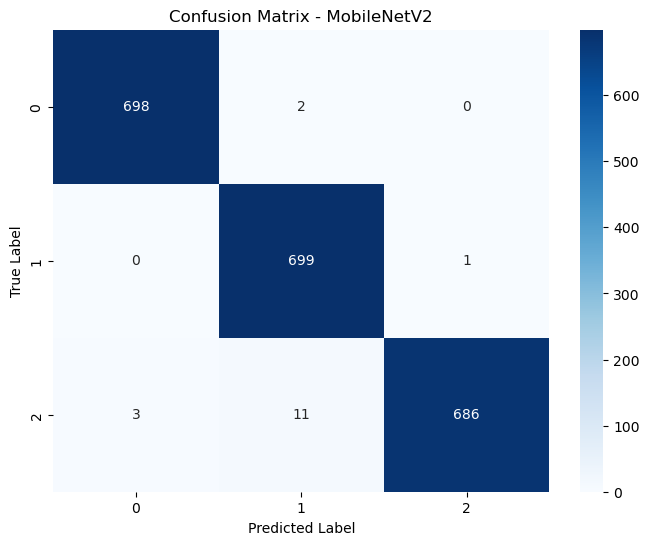


Confusion Matrix for Xception:


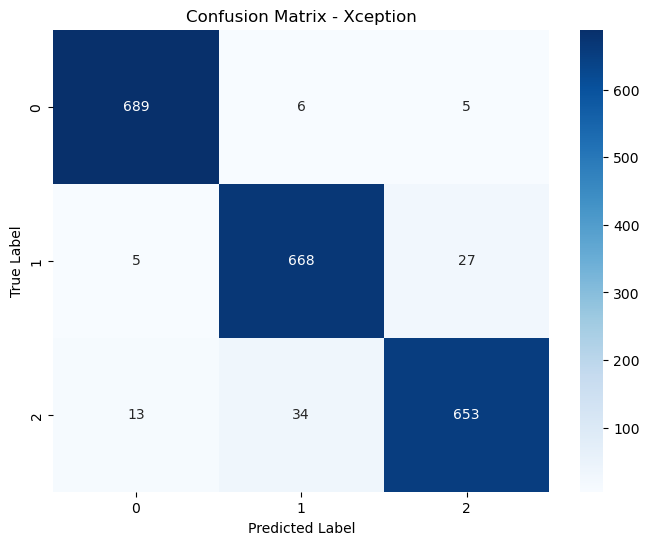


Confusion Matrix for ResNet50:


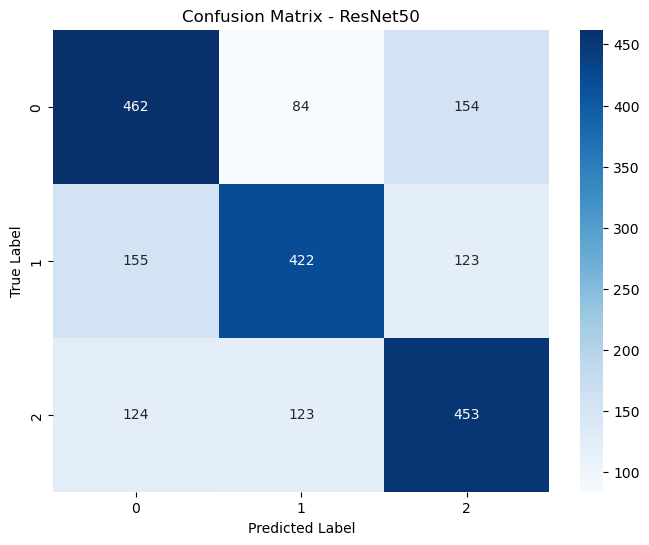

In [23]:
#---------------------------------------------------------------------
# 
#---------------------------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

for model_name in models_info.keys():
    print(f"\nConfusion Matrix for {model_name}:")
    y_true = labels_all[model_name]
    y_pred_probs = predictions_all[model_name]
    y_pred = np.argmax(y_pred_probs, axis=1)
    plot_confusion_matrix(y_true, y_pred, classes, model_name)

## 10. ROC curves

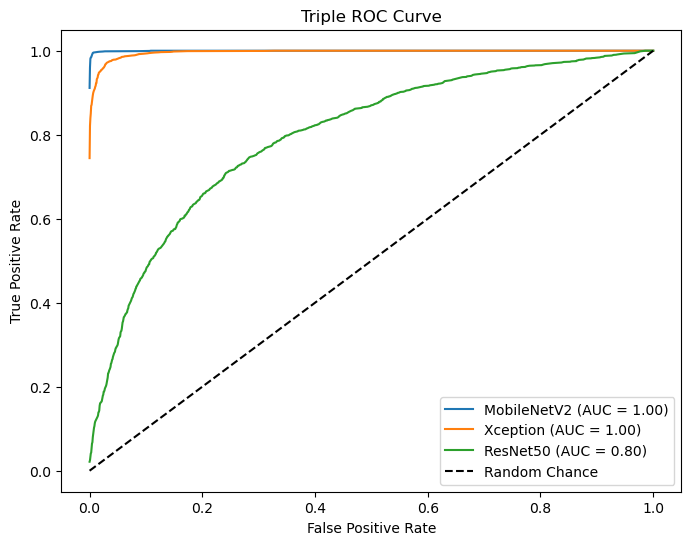

In [13]:
def compute_and_plot_roc(y_true, y_pred_probs, classes, model_name, ax=None):
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))
    
    # Calculate ROC curves for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if ax is None:
        ax = plt.gca()
    ax.plot(fpr["macro"], tpr["macro"], label=f'{model_name} (AUC = {roc_auc["macro"]:.2f})')

plt.figure(figsize=(8,6))
for model_name in models_info.keys():
    y_true = labels_all[model_name]
    y_pred_probs = predictions_all[model_name]
    compute_and_plot_roc(y_true, y_pred_probs, classes, model_name, ax=plt.gca())

plt.plot([0,1],[0,1],'k--', label='Random Chance')
plt.title('Triple ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## 11. Best ROC MobileNetV2

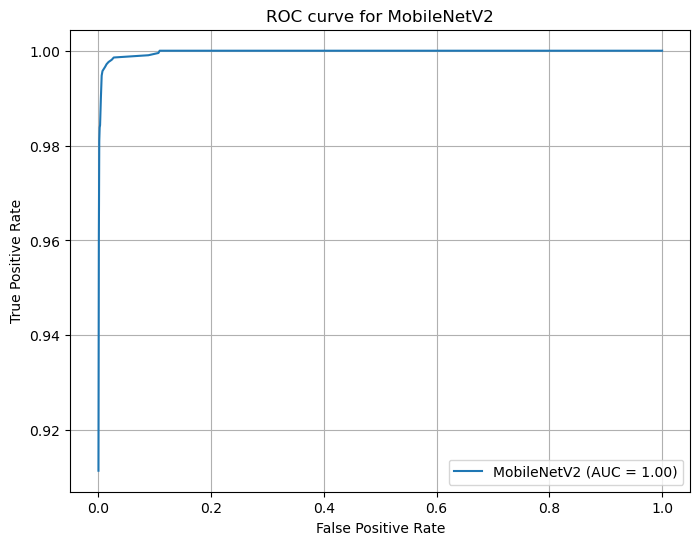

In [30]:
plt.figure(figsize=(8, 6))

# MobileNetV2
model_name = "MobileNetV2" 
y_true = labels_all[model_name]
y_pred_probs = predictions_all[model_name]

compute_and_plot_roc(y_true, y_pred_probs, classes, model_name, ax=plt.gca())

# Random Chance line 
#plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.title('ROC curve for MobileNetV2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## 12. Split the data into training and testing (80% - 20%)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.preprocessing import label_binarize

classes = [0, 1, 2]
y_test_bin = label_binarize(y_test, classes=classes)


## 13. Make probability predictions on the test set

In [ ]:
y_pred_probs = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 157s 9s/step


## 14. ROC Curve on Test Set

14/14 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step


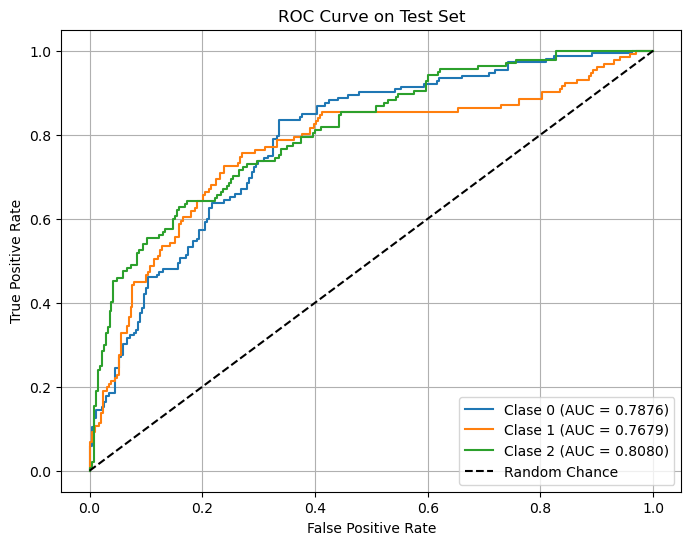

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  # Only use classes present in y_train

# Make predictions
y_pred_probs = model.predict(X_test)

# Calculate ROC and AUC only for classes with positive samples
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):  # Iterate over each class
    if np.sum(y_test_bin[:, i]) == 0:
        print(f"Class {i} has no positive samples in y_test, it will be skipped")
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC for the valid classes
plt.figure(figsize=(8, 6))
for i in roc_auc.keys():
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curve on Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
